In [64]:
import glob
import os
import torch
import cv2
import tqdm
import seaborn
import numpy as np
from IPython.display import display, Image
from matplotlib import pyplot as plt
from typing import Optional
import mediapipe as mp

In [14]:
# загружаем модельку, через sber может быть ошибка, поэтому лучше через sber guest
model_path = '/Users/20820480/Documents/c4e/best_yolov5s.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True)
model.conf = 0.5

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/20820480/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-3-24 Python-3.9.6 torch-2.0.0 CPU

Fusing layers... 
Model summary: 213 layers, 7031701 parameters, 0 gradients
Adding AutoShape... 


In [82]:
class Box:
    def __init__(self,
                 start_point: int, # верхний левый угол
                 end_point: int, # верхний правый угол
                 class_id: int,
                 conf: float):
        self.start_point = start_point
        self.end_point = end_point
        self.class_id = int(class_id)
        self.conf = conf
        self.keypoints = Optional[list]
    
    
def draw_rounded_corners(img, pt1, pt2, color, thickness, r, d=50, alpha=1):
    overlay = img.copy()
    original = img.copy() # To show no transparency
    x1,y1 = pt1
    x2,y2 = pt2
    # Top left
    cv2.line(overlay, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(overlay, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(overlay, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
    # Top right
    cv2.line(overlay, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(overlay, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(overlay, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
    # Bottom left
    cv2.line(overlay, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(overlay, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(overlay, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
    # Bottom right
    cv2.line(overlay, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(overlay, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(overlay, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)
    # Top left
    cv2.line(original, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(original, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(original, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
    # Top right
    cv2.line(original, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(original, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(original, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
    # Bottom left
    cv2.line(original, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(original, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(original, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
    # Bottom right
    cv2.line(original, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(original, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(original, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)
    result = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    return result

def draw_rounded_box(img, pt1, pt2, color, thickness, r, alpha=1):
    overlay = img.copy()
    original = img.copy() # To show no transparency
    
    x1,y1 = pt1
    x2,y2 = pt2
    # Top left
    cv2.line(overlay, (x1 + r, y1), (x2-r, y1), color, thickness)
    cv2.line(overlay, (x1, y1 + r), (x1, y2 - r), color, thickness)
    cv2.ellipse(overlay, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
    cv2.line(original, (x1 + r, y1), (x2-r, y1), color, thickness)
    cv2.line(original, (x1, y1 + r), (x1, y2 - r), color, thickness)
    cv2.ellipse(original, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
    # Top right
    # cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(overlay, (x2, y1 + r), (x2, y2 - r), color, thickness)
    cv2.ellipse(overlay, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
    cv2.line(original, (x2, y1 + r), (x2, y2 - r), color, thickness)
    cv2.ellipse(original, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
    # Bottom left
    cv2.line(overlay, (x1 + r, y2), (x2 - r, y2), color, thickness)
    cv2.line(original, (x1 + r, y2), (x2 - r, y2), color, thickness)
    # cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(overlay, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
    cv2.ellipse(original, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
    # Bottom right
    # cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    # cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(overlay, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)
    cv2.ellipse(original, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)
    
    result = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    return result

# Добавим сетку из медиапайпа
def draw_face_mesh(frame, meta, mesh_color, mesh_thickness, mesh_alpha):
    overlay = frame.copy()
    original = frame.copy()
    results = meta[1]
    # print(results)
    if results.multi_face_landmarks:
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y

                shape = frame.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])

                cv2.circle(frame, (relative_x, relative_y), radius=1, color=mesh_color, thickness=mesh_thickness)
                cv2.circle(frame, (relative_x, relative_y), radius=1, color=mesh_color, thickness=mesh_thickness)
                # frame = transparent_circle(frame, (relative_x, relative_y), radius=1, color=mesh_color, thickness=thickness, alpha=alpha)
        frame = cv2.addWeighted(overlay, mesh_alpha, frame, 1 - mesh_alpha, 0)
    return frame

In [77]:
def get_video_meta(video_path):
    video_meta = {}
    frame_number = 0
    cap = cv2.VideoCapture(video_path)
    mp_face_mesh = mp.solutions.face_mesh
 
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):
        # Capture frame-by-frame
        success, frame = cap.read()
        if success:
            video_meta[frame_number] = []
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = model(frame)
            meta_boxes=[]
            for box in results.xyxy[0]:
                start_point = (round(box[0].item()), round(box[1].item()))
                end_point = (round(box[2].item()), round(box[3].item()))
                class_id = box[5].item()
                conf = box[4].item()
                meta_box = Box(start_point, end_point, class_id, conf)
                meta_boxes.append(meta_box)
                # cv2.rectangle(frame, start_point, end_point, color, thickness)
            # Display the resulting frame
            # cv2.imshow('Frame',frame)
            video_meta[frame_number].append(meta_boxes)
            
            with mp_face_mesh.FaceMesh(min_detection_confidence=0.5) as face_mesh:
                results = face_mesh.process(frame)
            video_meta[frame_number].append(results)
            frame_number += 1

          # Break the loop
        else: 
            break
# When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    return video_meta

In [71]:
def plot_video_meta(video_path, video_meta, colors_dict, thickness, curve_corner,alpha=1, style='box',corners_lenght=50, mesh = True, mesh_thickness=1, mesh_alpha=0.5):
    
    cap = cv2.VideoCapture(video_path)
    
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = int(cap.get(5))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, fps, (frame_width,frame_height))
    frame_number = 0
 
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):
        # Capture frame-by-frame
        success, frame = cap.read()
        if success:
            frame_meta = video_meta[frame_number]
            out_frame = frame.copy()
            for box in frame_meta[0]:
                if box.class_id in colors_dict.keys():
                    if style == 'box':
                        out_frame = draw_rounded_box(out_frame, box.start_point, box.end_point, colors_dict[box.class_id], thickness, curve_corner, alpha)
                    elif style == 'corners':
                        out_frame = draw_rounded_corners(out_frame, box.start_point, box.end_point, colors_dict[box.class_id], thickness, curve_corner, corners_lenght, alpha)
            if mesh:
                frame = draw_face_mesh(out_frame, frame_meta[1], colors_dict['mesh'], mesh_thickness, mesh_alpha)
                    # cv2.rectangle(frame, box.start_point, box.end_point, color, thickness)
            frame_number += 1
            out.write(out_frame)
        else:
            break
    out.release()
    cap.release()
    return

In [87]:
# Собираем мету с моделей, запускать достатоно один раз для одного видео
video_path = '/Users/20820480/Documents/c4e/_import_618a61406b2df3.96865262.mov'
video_meta = get_video_meta(video_path)

In [103]:
# Меняем эти параметры, смотрим на отрисовку на первом кадре
thickness = 2 # толщина
alpha=0.5 # прозрачность линии бокса
curve_corner = 50 # закругление углов
style = 'box' # либо 'box' либо 'corners', default for video ='box'
corners_lenght = 50 # только для style = 'corners' длина линии от угла
colors_dict = {
    0 : (255, 0, 0), # person
    1 : (177, 177, 177), # face
    4 : (0, 255, 255), # head
    "mesh" : (0,255,0)
} # закомментируй класс который не нужно отрисовывать

# Для сетки лица
mesh = False # нужна ли отрисовка лица или нет
mesh_alpha = 0.5
mesh_thickness=1

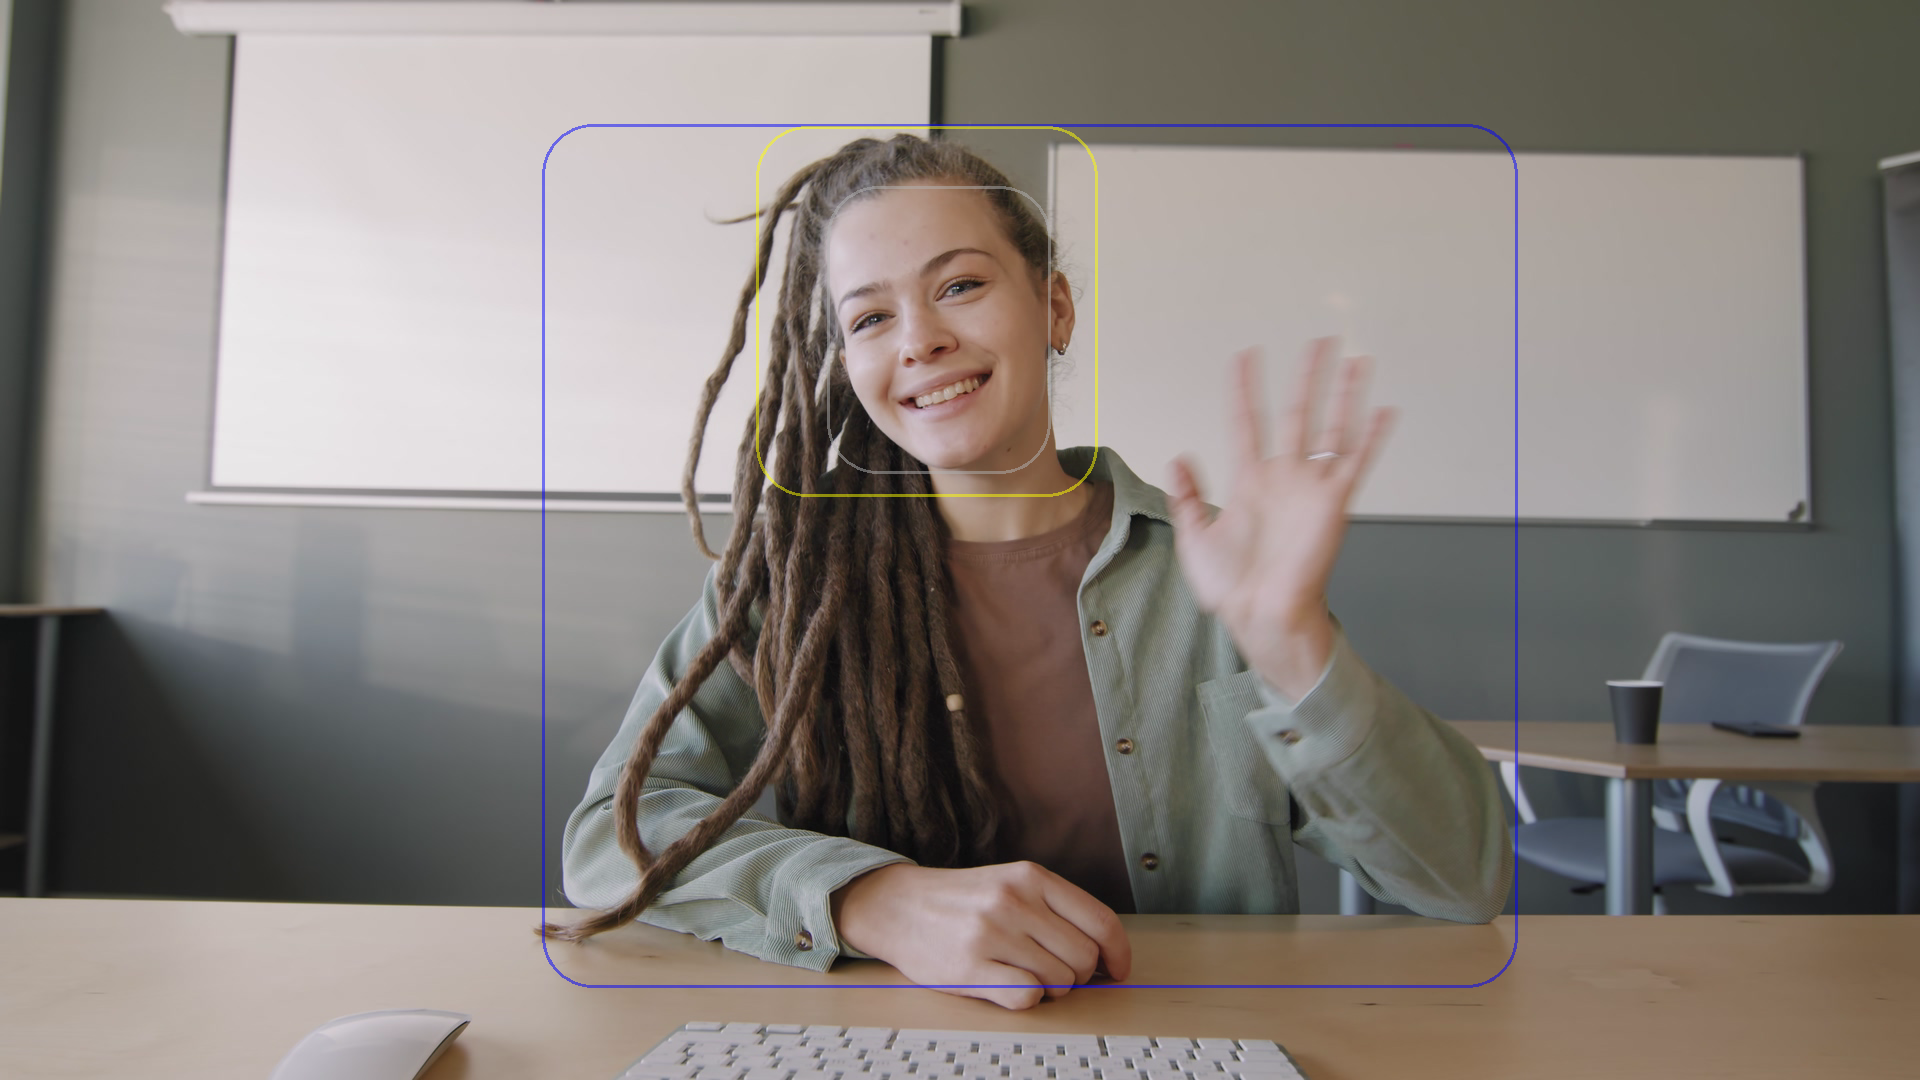

In [104]:
# делаем отрисовку на первом кадре
cap = cv2.VideoCapture(video_path)
success, frame = cap.read()
cap.release()
# cv2.imwrite('frame0.png', frame)
frame_meta = video_meta[0]
for box in frame_meta[0]:
    if box.class_id in colors_dict.keys():
        if style == 'box':
            frame = draw_rounded_box(frame, box.start_point, box.end_point, colors_dict[box.class_id], thickness, curve_corner, alpha)
        elif style == 'corners':
            frame = draw_rounded_corners(frame, box.start_point, box.end_point, colors_dict[box.class_id], thickness,curve_corner, corners_lenght,alpha)
if mesh:
    frame = draw_face_mesh(frame, frame_meta[1], colors_dict['mesh'], mesh_thickness, mesh_alpha)
            
cv2.imwrite('output_frame0.png', frame)
Image('output_frame0.png')

In [89]:
# Отрисовка полного видео
plot_video_meta(video_path, video_meta, colors_dict, thickness, curve_corner, alpha, style, corners_lenght,mesh, mesh_thickness, mesh_alpha)